# **Projet MACS207b**  - Filtrage
- Rendu le 10 juin 2022

**Timothée LY, Louis PERSONNAZ**

# 1 - Présentation du problème

**Hypothèses :**

2 processus de Poisson indépendants $N_a$ et $N_b$, on observe $N_a$ puis $N_b$ après $\tau$
- $\tau \sim \mathcal{E}(\mu)$ avec $\mu = 0.2$ et $\tau$ indépendant de $N_a$, $N_b$
- $a = 5$ et $b = 10$

**But :** on veut estimer $\tau$ à travers l'observation des instants de saut du processus ponctuel "concaténé" $N$

**Notations :** $\tau$ a pour densité $f$ et fonction de répartition $F$ 

# 2 - Résolution et implémentation

On calcule la fonction $h$ donnée par :
$$h(s) = \dfrac{f(s)}{1-F(s)}$$

Pour une loi exponentielle d'intensité $\mu$: 

$\forall s \in \mathbb{R}, \ f(s) = \mu e^{-\mu s} \mathbb{1}_{\mathbb{R}^+}(s)$

$\forall s \in \mathbb{R}, \ F(s) = (1 - e^{-\mu s}) \mathbb{1}_{\mathbb{R}^+}(s)$

d'où l'on tire

$$
\begin{align*}
\forall s \in \mathbb{R}^+, \quad h(s)
&= \dfrac{ \mu e^{-\mu s}}{1-(1 - e^{-\mu s})} \\
&= \dfrac{ \mu e^{-\mu s}}{e^{-\mu s}} \\
&= \mu
\end{align*}
$$

<u> Application numérique :</u>  $h(s) = 0.2 \, \mathbb{1}_{s \ge 0}$

### Imports

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
mu = 0.2
h = lambda s : mu if s > 0 else 0
a = 5
b = 10

In [3]:
def poisson_proc(lmbda, beg, T, seed):
    """
    génère des instants d'arrivée d'un processus de Poisson
    lmbda: intensité
    beg: origine des temps
    T: horizon des temps
    """
    if T < beg : return []
    rng = np.random.default_rng(seed)
    k = rng.poisson(lmbda * T)
    arrivals = rng.uniform(beg, T, k)
    
    return np.sort(arrivals)   

In [4]:
tau_dist = lambda rng : rng.exponential(1/mu)

Z = lambda t, tau : 1 if (tau <= t) else 0

N = lambda a, b, t, tau : (a + (b-a) * Z(t, tau)) * t

In [5]:
def trajectory(n, a, b, seed, beg=0, end=10):
    """
    affiche la trajectoire d'une observation aléatoire
    n: nombre de points pour l'affichage
    a, b: intensités
    beg, end: bornes des temps
    """
    rng = np.random.default_rng(seed) # initialiser le rng
    tau = tau_dist(rng)               # tirer un tau aléatoire
    # générer les temps d'arrivée avant et après tau
    arrivals = np.concatenate((poisson_proc(a, beg, tau, seed),
                               poisson_proc(a, tau, end, seed)))
    
    plt.figure(figsize=(10, 5))
    plt.step(arrivals, np.arange(arrivals.size))
    plt.axvline(tau, linestyle=':', c='firebrick')
    plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
    plt.xlim(beg, end)
    plt.title(fr"Trajectoire pour $\tau =${tau:.2f}")
    plt.ylabel(r"$N(t)$")
    plt.xlabel(r"$t$")
    plt.show()
    
    return arrivals, tau

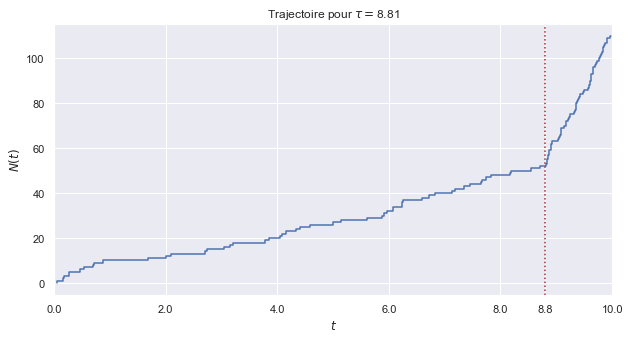

In [6]:
n = 1000
beg, end = 0, 10
arrivals, tau = trajectory(n, a, b, 1789)

On peut montrer que (cf. exercice 2.2 — Détection de changement de régime du poly) :
- les instants de saut de Z sont ceux de N
-
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t [h(s) - (b-a)\hat{Z}(s)] (1 - \hat{Z}(s)) \, \mathrm{d} s$$
d'où
$$\forall t \in ]T_n, T_{n+1}[, \quad \hat{Z}'(t) = [h(t) - (b-a)\hat{Z}(t)] (1 - \hat{Z}(t))$$
-
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a) \hat{Z}(T_n^-) (1-\hat{Z}(T_n^-))}{a + (b-a) \hat{Z}(T_n^-)}$$

In [7]:
derivative = lambda z, t : (h(t) - (b-a)*z) * (1-z)

In [8]:
def flatten_to_array(l):
    t = []
    for e in l:
        if isinstance(e, float):
            t.append(e)
        if isinstance(e, np.ndarray):
            t += e.tolist()
    return np.array(t)

In [9]:
def saut(ZTn_, a, b):
    return (b-a) * ZTn_ * (1 - ZTn_) / (a + (b-a) * ZTn_)

In [10]:
def Z_hat(arrivals, beg=0, end=10):
    """
    calcule l'estimation de Z à partir de l'observation des sauts
    """
    m = arrivals.size
    ts = []     # temps
    Z_hats = [] # valeurs de Z_hat
    z0 = 0      # valeur initiale
    
    # segment [beg, T_0]
    n_points = int(np.ceil(100 * max(a,b) * arrivals[0]))
    t = np.linspace(0, arrivals[0], n_points, endpoint=False)
    ts.append(t)
    Z_hats.append(odeint(derivative, z0, t).ravel())
    ts.append(arrivals[0]) # rajouter ce temps exclu ci-dessus
    Z_hats.append(saut(Z_hats[-1][-1], a, b)) # prendre pour ZTn_ la dernière valeur estimée
    
    for n in range(m-1):
        # segment [T_n, T_{n+1}]
        n_points = int(np.ceil(20 * max(a,b) * (arrivals[n+1] - arrivals[n])))
        t = np.linspace(arrivals[n], arrivals[n+1], n_points, endpoint=False)
        ts.append(t)
        Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
        ts.append(arrivals[n+1])
        Z_hats.append(saut(Z_hats[-1][-1], a, b))
        
    # segment [T_{m-1}, end]
    n_points = int(np.ceil(20 * max(a,b) * (end - arrivals[-1])))
    t = np.linspace(arrivals[-1], end, n_points, endpoint=True)
    ts.append(t)
    Z_hats.append(odeint(derivative, Z_hats[-1], t).ravel())
    
    return flatten_to_array(ts), flatten_to_array(Z_hats)

In [11]:
ts, Z_hats = Z_hat(arrivals)

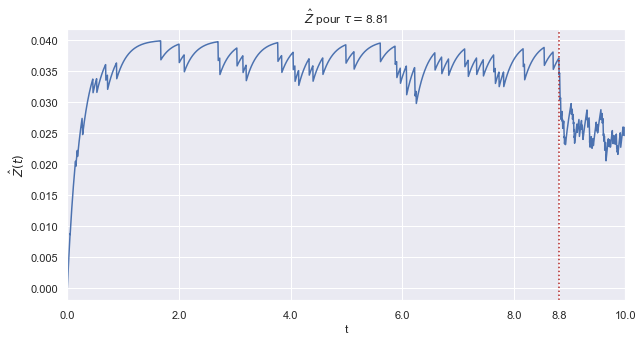

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(ts, Z_hats)
plt.axvline(tau, linestyle=':', c='firebrick')
plt.xticks(list(plt.xticks()[0]) + [tau]) # ajouter 1 tick à l'abscisse tau
plt.xlim(beg, end)
plt.title(fr"$\hat{{Z}}$ pour $\tau =${tau:.2f}")
plt.ylabel(r'$\hat{Z}(t)$')
plt.xlabel("t")
plt.show()